<a href="https://colab.research.google.com/github/brromeroc/Codigos-del-proyecto-Revision-de-conceptos-asociados-al-c-alculo-de-componentes-Principales/blob/main/VAEPROYECTODEGRADO_CHICAGO_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Método proyectado de potencias, sobre la imagen de un codificador automatico variacional**

##**Recuersos**

A continuación vamos a cargar todos las librerias,  que necesitaremos para nuestro estudio del método de potencias utilizando la imagen normalizada del decoder de un codificador automatico variacional (VAE por sus siglas en ingles).  Para el estudio de redes neuronales utilizamos la libreria Tensorflow que nos da herramientas para implementar las arquitecturas correspondientes a un VAE, las cuales se detallan mas en el articulo anexo a este código (se recomienda leer el capitulo correspiente a preliminares y el capitulo de Componentes principales, utilizando el rango de un operado)

In [64]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Dropout,Input,Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import plotly.express as px
import sys
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


También vamos a cargar los datos correspondinte a imagenes de caras tomadas en la Universidad de chicago [4], hicimos dos reescalamientos de estas imagenes, la primera para convertirlas en tensores de tamaño $119\times119\times3$ ($3$ canales de color RGB)y el segundo para convertirlas en tensores de tamaño $28\times 28\times3$, esta división se hizo para dos propositos.

1. los tensores de tamaño $119\times119\times3$ solo se utilizaron para entrenar un VAE con dimensión latente 2 y sirve como ejemplo para visualizar la distribución de los datos en este espacio.

2. Dado que los calculos computacionales se hacian bastante demorados con las imanages de dimensiones $119\times119\times3$, se opto por reescalarlas a imagenes de tamaño $28\times 28\times3$. con estas ultimas se hace todo el estudio del método proyectado de potencias.

Ahora bien dado que ya conocemos las razones de la división de tamaños de imagenes, pasamos a nombrar los tensores importantes (notaremos por $p$ la cantidad de imagenes, $m$ el largo de la imagen, $n$ el ancho de la imagen y $c$ la cantidad de canales de color), para este caso, tenemos que:


* $Images:$ Es el tensor de tamaño $p\times m\times n\times c$ que contiene todas las imagenes de caras del data set de la universidad de Chicago.

* $Imagen promedio:$ Es el tensor de tamaño $m\times n\times c$ que contiene el resultado de sumar las imagenes de $Images$ y dividielo por el total de imagenes.

* $M:$  Es el tensor de tamaño $p\times m\times n\times c$ que consiste de tomar a Images y restar a cada cara la cara promedio.

* $Sigma:$ Es el tensor de tamaño $p\times p\times c$ que resulta de hacer la multiplicacion de $M$ por su transpuesta en cada canal.

* $SigmaT:$ Es el tensor de tamaño $m*n\times m*n\times c$ que resulta de hacer la multiplicacion de $M^T$ por su transpuesta en cada canal.

###**Imagenes de tamaño $119\times 119$**

In [80]:
#Cargar tensores importantes M,Sigma y Imagen_promedio, todos estan normalizados (./255)
c=3
m=119
n=119
p=821
M119=np.loadtxt('/content/drive/MyDrive/MODELOPROYECTODEGRADO/MatrizM119.csv',delimiter=',').reshape(p,m,n,3)    # tamaño guardado (p,m*n*c)
Imagen_promedio119= np.loadtxt('/content/drive/MyDrive/MODELOPROYECTODEGRADO/imagenpromedio119.csv',delimiter=',').reshape(m,n,3)     #Tamaño guardado (m*n,c)
Sigma119 = np.loadtxt('/content/drive/MyDrive/MODELOPROYECTODEGRADO/Sigma119.csv',delimiter=',').reshape((p,p,c))    #tamaño guadado (p*p,c)
Images119 = np.loadtxt('/content/drive/MyDrive/MODELOPROYECTODEGRADO/Images.csv',delimiter=',').reshape((p,m,n,c))    #Tamaño guardado (p,m*n*c)


La base de datos de rostros de chicago, desarrollada en la Universidad de Chicago es una herramienta diseñada para la investigación científica. Esta base de datos ofrece fotografías de alta resolución y estandarizadas de rostros masculinos y femeninos de diversas etnias, con edades comprendidas entre 17 y 65 años. El conjunto de datos está compuesto por $821$ fotografías de caras tomadas de personas de diferentes etnias y razas reclutadas en los Estados Unidos y en India. En algunas fotografías se muestran diferentes expresiones de un mismo individuo. A continuación visualizamos la primera cara de este data set, reesclada (es un tensor de $119\times 119\times 3$, a diferencia de su version original de tamaño $2444\times 1718\times 3$ )

In [81]:
fig = px.imshow(Images119[0,:,:,:])
fig.update_traces(hoverinfo='z')
fig.update_layout(
    coloraxis_showscale=True,
    title={
        'text': "Primera cara del data set",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 24  # Cambia el valor para ajustar el tamaño de la letra
        }
    }
)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show(renderer="colab")


###**Imagenes de tamaño $28\times 28$**

En esta parte vamos a cargar las mismas imágenes, pero reescaladas a tamaño $28\times 28\times 3$, principalmente trabajaremos con estas pues los calcul0s computacionales son mucho más rápidos.

In [69]:
c=3
m=28
n=28
p=821
M=np.loadtxt('/content/drive/MyDrive/MODELOPROYECTODEGRADO/MatrizM28.csv',delimiter=',').reshape(p,m,n,3)    # tamaño guardado (p,m*n*c)
Imagen_promedio= np.loadtxt('/content/drive/MyDrive/MODELOPROYECTODEGRADO/imagenpromedio28.csv',delimiter=',').reshape(m,n,3)     #Tamaño guardado (m*n,c)
Sigma = np.loadtxt('/content/drive/MyDrive/MODELOPROYECTODEGRADO/Sigma28.csv',delimiter=',').reshape((p,p,c))    #tamaño guadado (p*p,c)
SigmaT = np.loadtxt('/content/drive/MyDrive/MODELOPROYECTODEGRADO/SigmaT28.csv',delimiter=',').reshape((m*n, m*n, c))    #tamaño guadado (m*n*m*n,c)
Images = np.loadtxt('/content/drive/MyDrive/MODELOPROYECTODEGRADO/Images28.csv',delimiter=',').reshape((p,m,n,c))    #Tamaño guardado (p,m*n*c)

In [70]:

fig = px.imshow(Images[0,:,:,:])
fig.update_traces(hoverinfo='z')
fig.update_layout(
    coloraxis_showscale=True,
    title={
        'text': "Primera cara del data set",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 24  # Cambia el valor para ajustar el tamaño de la letra
        }
    }
)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show(renderer="colab")

##**Codificador Automático Variacional**

Ahora vamos a implementar la estructura del vae con el que trabajaremos de aqui en adelante, para ello utilizamos un decoder con  la siguiente arquitectura:

1. **Entrada**$(m,n,c)$: Imágenes de tamaño $(m, n, c)$.
2. **Flatten**$(m,n,c)$: Aplana la imagen en un vector,
3. **Dense**(512, activation=relu): Capa densa con 512 neuronas y activación ReLU.
4. **Dense**$(256, activation=relu)$: Capa densa con 256 neuronas y activación ReLU.
5. **Dense**$(latent_.dim)$: Capa densa con latent_dim neuronas, sin activación, para z_mean.
6. **Dense**$(latent_.dim)$: Capa densa con latent_dim neuronas, sin activación, para z_log_var.

Para el cuello de botella, se implementa la función sampling que toma la media  y la varianza logaritmica (z_mean y z_log_var) que sale del encoder  y retorna una muestra de la distribución normal con estos parametros.

Para el decoder tenemos la siguiente arquitectura:

1. **Entrada**$(latent_.dim)$: Vector latente $z$ de tamaño latent_dim.
2. **Dense**$(256, activation=relu)$: Capa densa con 256 neuronas y activación ReLU.
3. **Dense**$(512, activation=relu)$: Capa densa con 512 neuronas y activación ReLU.
4. **Dense**$(m * n * c, activation=sigmoid)$: Capa densa con $m\times n \times c$ neuronas y  activación sigmoide, que produce una imagen aplanada.
6. **Reshape**$((m, n, c))$: Da forma a la salida para que coincida con la imagen original


Para el caso de las imagnes de tamaño $119\times 119\times 3$ el numero de parametros fue:

1. Parámetros del encoder: 21,926,131
2. Parámetros del decoder: 21,926,131
3. Parámetros del del VAE: 43,810,295


###**Arquitectura del codificador automático variacional**

In [71]:
# Registrar la función de muestreo
@tf.keras.utils.register_keras_serializable()
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Registrar la clase VAELossLayer
@tf.keras.utils.register_keras_serializable()
class VAELossLayer(Layer):
    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        reconstruction_loss = mse(K.flatten(x), K.flatten(x_decoded_mean))
        reconstruction_loss *= m * n * c
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(vae_loss)
        return x_decoded_mean

# Suponiendo que tu nuevo dataset está cargado en una variable llamada Mchicagored_normalized
data = M

# Añadir una dimensión extra para el canal de color si no está presente
if data.shape[-1] != 3:
    data = np.tile(data, (1, 1, 1, 3))

# Asegurarse de que los datos están en el rango adecuado (0 a 1)
data = np.clip(data, 0, 1)

# Dividir en conjuntos de entrenamiento y prueba
train_data = data[:700]
test_data = data[700:]

# Dimensiones de la entrada
m, n, c = data.shape[1:]

# Definir la arquitectura del VAE
latent_dim = 30  # Dimensión del espacio latente

# Encoder
inputs = Input(shape=(m, n, c))
x = Flatten()(inputs)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(512, activation='relu')(x)
x = Dense(m * n * c, activation='sigmoid')(x)
outputs = Reshape((m, n, c))(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Añadir la capa de pérdida personalizada al modelo
loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var])
vae = Model(inputs, loss_layer)

# Reducir la tasa de aprendizaje
optimizer = Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer)
vae.summary()

# Entrenamiento del VAE
vae.fit(train_data, epochs=100, batch_size=32, validation_data=(test_data, None))

# Guardar los modelos con las extensiones correctas
vae_save_path = '/content/drive/MyDrive/MODELOPROYECTODEGRADO/vae_model_latent30_img28_M.h5'
encoder_save_path = '/content/drive/MyDrive/MODELOPROYECTODEGRADO/encoder_model_latent30_img28_M.h5'
decoder_save_path = '/content/drive/MyDrive/MODELOPROYECTODEGRADO/decoder_latent30_img28_M.h5'
vae.save(vae_save_path)
encoder.save(encoder_save_path)
decoder.save(decoder_save_path)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 2352)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 512)            │      1,204,736 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │        131,328 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 30)             │          7,710 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 30)             │          7,710 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 30)             │              0 │ dense_9[0][0],         │
│                           │                        │                │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,351,484 (5.16 MB)

 Trainable params: 1,351,484 (5.16 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2352)                │       1,206,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 28, 28, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,346,096 (5.13 MB)

 Trainable params: 1,346,096 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 2352)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 512)            │      1,204,736 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 30), (None,    │      1,351,484 │ input_layer_2[0][0]    │
│                           │ 30), (None, 30)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │        131,328 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 28, 28, 3)      │      1,346,096 │ encoder[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 30)             │          7,710 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 30)             │          7,710 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vae_loss_layer_1          │ (None, 28, 28, 3)      │              0 │ input_layer_2[0][0],   │
│ (VAELossLayer)            │                        │                │ decoder[0][0],         │
│                           │                        │                │ dense_9[0][0],         │
│                           │                        │                │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,697,580 (10.29 MB)

 Trainable params: 2,697,580 (10.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 243.8059 - val_loss: 25.8206
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 25.6068 - val_loss: 22.0663
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 22.7664 - val_loss: 21.2733
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 21.8746 - val_loss: 21.1565
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 22.2378 - val_loss: 21.4250
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 20.9685 - val_loss: 20.1049
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 19.4701 - val_loss: 19.5382
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 18.1169 - val_loss: 19.7000
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 18.3169 - val_loss: 19.1494
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 18.3649 - val_loss: 18.5060
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 18.0673 - val_loss: 19.1078
Epoch 12/100
22/22 ━━━━━━━━━━

###**Cargar decoder y encoder latent_Dim=2**

Ahora cargamos los datos del VAE, entrando con las imagenes de tamaño $119\times 119\times 3$, dimension latente 2, tasa de aprendizaje 0.001, epocas 10 y tamaño de lote tamaño del lote 32

In [82]:
#Cargar las configuarciones del encoder y el decoder
vae_save_path = '/content/drive/MyDrive/MODELOPROYECTODEGRADO/vae_model_latent.h5'
encoder_save_path = '/content/drive/MyDrive/MODELOPROYECTODEGRADO/encoder_model_latent.h5'
decoder_save_path = '/content/drive/MyDrive/MODELOPROYECTODEGRADO/decoder_latent.h5'

vae = tf.keras.models.load_model(vae_save_path, custom_objects={'sampling': sampling, 'VAELossLayer': VAELossLayer})
encoder = tf.keras.models.load_model(encoder_save_path, custom_objects={'sampling': sampling, 'VAELossLayer': VAELossLayer})
decoder = tf.keras.models.load_model(decoder_save_path, custom_objects={'sampling': sampling, 'VAELossLayer': VAELossLayer})

In [83]:
#Cargar la media
z_mean, z_log_var, z = encoder.predict(M119)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Ahora gráficamos las imagenes  por medio del encoder, de las imagenes del Data-set.

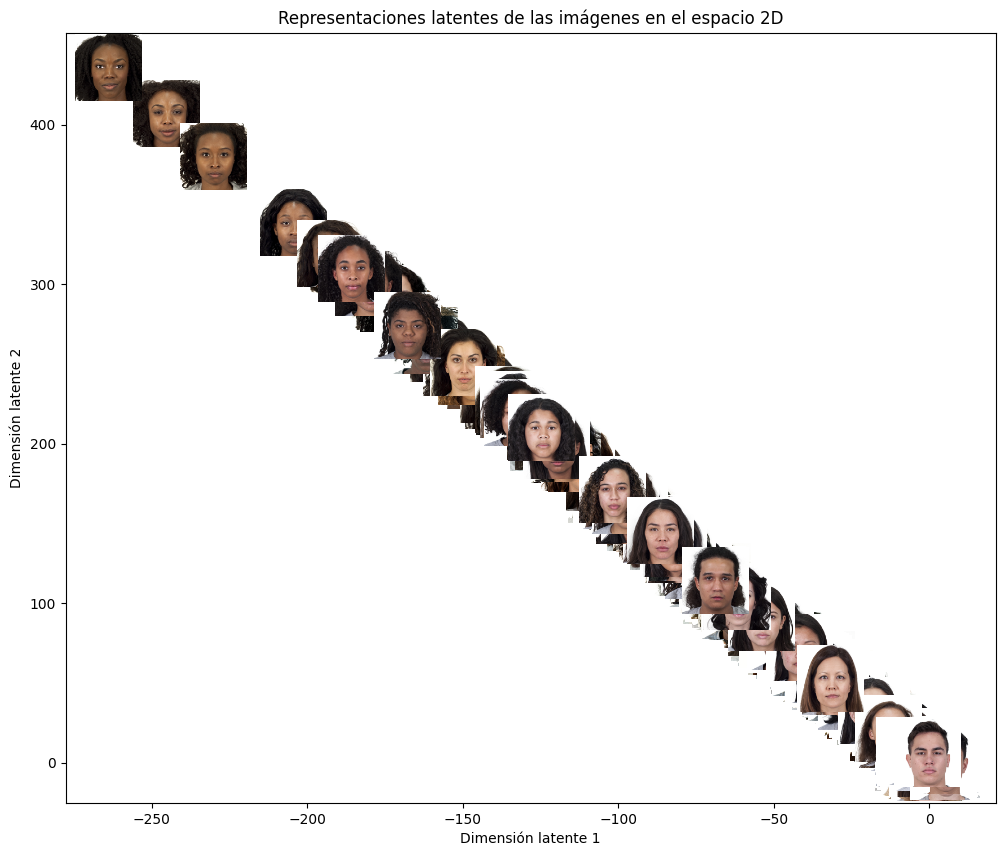

In [84]:
def plot_latent_images(z_mean, data):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.scatter(z_mean[:, 0], z_mean[:, 1])

    for i in range(len(z_mean)):
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(data[i], cmap='gray', zoom=0.4),
            z_mean[i],
            frameon=False)
        ax.add_artist(imagebox)

    plt.title('Representaciones latentes de las imágenes en el espacio 2D')
    plt.xlabel('Dimensión latente 1')
    plt.ylabel('Dimensión latente 2')
    plt.show()

# Llamada a la función para mostrar las imágenes
data=Images119
plot_latent_images(z_mean, data)

Además graficamos, las decodificaciones de varios puntos en el espacio latente, vemos que se relaciona en cierta medida (facciones, color de piel, cabello) con las imagnes por medio del encoder

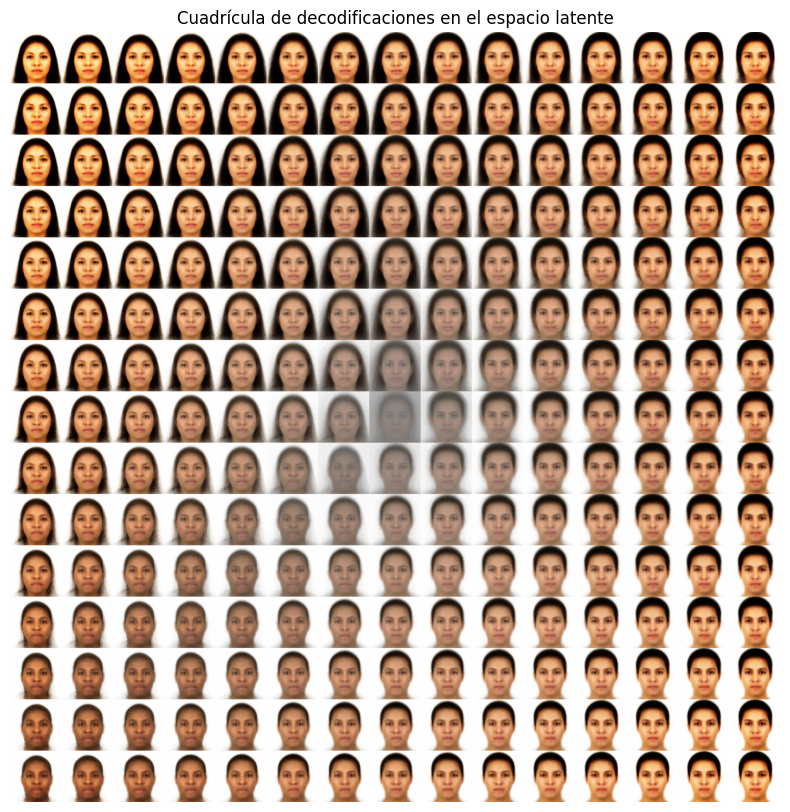

In [85]:


# Crear una cuadrícula de puntos en el espacio latente
l = 15  # número de puntos por dimensión
grid_x = np.linspace(-20, 20, l)
grid_y = np.linspace(-20, 20, l)

# Suprimir la salida de progreso durante las predicciones
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

# Decodificar los puntos de la cuadrícula
figure = np.zeros((119 * l, 119 * l, 3))

with HiddenPrints():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(119, 119, 3)
            figure[i * 119: (i + 1) * 119,
                   j * 119: (j + 1) * 119] = digit

# Visualizar la cuadrícula de imágenes decodificadas
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.title('Cuadrícula de decodificaciones en el espacio latente')
plt.axis('off')
plt.show()

###**Cargar decoder y encoder latem_dim=30 entrenado con Images**

Ahora cargamos los datos del VAE, entrando con las imagenes de tamaño $28\times 28\times 3$, dimension latente $2$, tasa de aprendizaje $0.001$, epocas $100$ y tamaño de lote tamaño del lote $32$

In [5]:
#Cargar las configuarciones del encoder y el decoder
vae_save_path30 = '/content/drive/MyDrive/MODELOPROYECTODEGRADO/vae_model_latent30_img28.h5'
encoder_save_path30 = '/content/drive/MyDrive/MODELOPROYECTODEGRADO/encoder_model_latent30_img28.h5'
decoder_save_path30 = '/content/drive/MyDrive/MODELOPROYECTODEGRADO/decoder_latent30_img28.h5'

vaeimg30 = tf.keras.models.load_model(vae_save_path30, custom_objects={'sampling': sampling, 'VAELossLayer': VAELossLayer})
encoderimg30 = tf.keras.models.load_model(encoder_save_path30, custom_objects={'sampling': sampling, 'VAELossLayer': VAELossLayer})
decoderimg30 = tf.keras.models.load_model(decoder_save_path30, custom_objects={'sampling': sampling, 'VAELossLayer': VAELossLayer})




In [6]:
latent_sample = np.array([[0, 0,0,0 ,0,0,0,0,0,0,0, 0,0, 0,0,0,0,0,0,0,0, 0,0, 0,0,0,0,0,0,0]])  # Punto en el espacio latente
reconstructed_image = decoderimg30.predict(latent_sample)

# Remover la dimensión del canal si es necesario
reconstructed_image = np.squeeze(reconstructed_image)

fig = px.imshow(reconstructed_image)
fig.update_traces(hoverinfo='z')
fig.update_layout(coloraxis_showscale=True)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show(renderer="colab")
norm  = tf.norm(reconstructed_image, ord='euclidean')
print(norm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


tf.Tensor(33.707657, shape=(), dtype=float32)


###**Cargar decoder y encoder latem_dim=30, entrando con M**

Ahora cargamos los datos del VAE, entrando con la Matriz $M$, que son $821$  imagenes de tamaño $28\times 28\times 3$ restandole la cara promedio,lo entrenamos con los siguientes hiperparametros dimension latente $2$, tasa de aprendizaje $0.001$, epocas $100$ y tamaño de lote tamaño del lote $32$

In [7]:
#Cargar las configuarciones del encoder y el decoder
vae_save_path30 = '/content/drive/MyDrive/MODELOPROYECTODEGRADO/vae_model_latent30_img28_M.h5'
encoder_save_path30 = '/content/drive/MyDrive/MODELOPROYECTODEGRADO/encoder_model_latent30_img28_M.h5'
decoder_save_path30 = '/content/drive/MyDrive/MODELOPROYECTODEGRADO/decoder_latent30_img28_M.h5'


vaeM30 = tf.keras.models.load_model(vae_save_path, custom_objects={'sampling': sampling, 'VAELossLayer': VAELossLayer})
encoderM30 = tf.keras.models.load_model(encoder_save_path, custom_objects={'sampling': sampling, 'VAELossLayer': VAELossLayer})
decoderM30 = tf.keras.models.load_model(decoder_save_path, custom_objects={'sampling': sampling, 'VAELossLayer': VAELossLayer})

In [8]:

latent_sample = np.zeros(latent_dim)
latent_sample = np.expand_dims(latent_sample, axis=0) # Punto en el espacio latente
reconstructed_image = decoderM30.predict(latent_sample)

# Remover la dimensión del canal si es necesario
reconstructed_image_M = np.squeeze(reconstructed_image)

fig = px.imshow(reconstructed_image_M)
fig.update_traces(hoverinfo='z')
fig.update_layout(coloraxis_showscale=True)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show(renderer="colab")
norm  = tf.norm(reconstructed_image_M, ord='euclidean')
print(norm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


tf.Tensor(6.6889057, shape=(), dtype=float32)


##**Metodo proyectado de potencias**

###**Proyección sobre imagen del decoder**

Ahora implementamos la proyeccion de [1], que consiste en lo siguiente.

Sea $\hat{G}$ el decoder de un VAE, defina $G(x)=\frac{\hat{G}(x)}{||\hat{G}(x)||_2}$ como la normalización de nuestro modelo, la proyección sobre la imagen normalizada se define como:

 $$\mathcal{P}_G(x)=\arg\min_{w\in Im(G)}||x-w||_2$$

 Ahora esto último hallara el vector propio asociado al  valor propio de mayor magnitud. Para nuestro codigo hicimos dos proyecciones una donde solo proyecta sobre la imagen de $\hat{G}$ (y la normalización se conseguiria dividiendo entre la norma del vector resultante de aplicar la función (project)) y otro en donde se hace la proyección normalizada (project_normalized)

In [86]:
# Función para proyectar en el rango del decoder normalizado
def project(decoder, x, iterations=100, learning_rate=0.6):
    latent_dim = decoder.input_shape[1]
    z = tf.Variable(np.random.randn(1, latent_dim), dtype=tf.float32)  # Inicialización aleatoria de z
    x= np.expand_dims(x, axis=0)

    optimizer = tf.optimizers.Adam(learning_rate)

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            reconstruction = decoder(z)
            loss = tf.reduce_mean(tf.square(reconstruction - x))

        grads = tape.gradient(loss, [z])
        optimizer.apply_gradients(zip(grads, [z]))
        proyeccion=decoder(z).numpy()

    return proyeccion.squeeze()

def project_normalized(decoder, x, iterations=100, learning_rate=0.6):
    latent_dim = decoder.input_shape[1]
    z = tf.Variable(np.random.randn(1, latent_dim), dtype=tf.float32)  # Inicialización aleatoria de z
    x = np.expand_dims(x, axis=0)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x = tf.convert_to_tensor(x, dtype=tf.float32) / tf.norm(x, ord='euclidean')

    optimizer = tf.optimizers.Adam(learning_rate)

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            reconstruction = decoder(z)
            reconstruction_normalized = reconstruction / tf.norm(reconstruction, ord='euclidean')
            loss = tf.reduce_mean(tf.square(reconstruction_normalized - x))

        grads = tape.gradient(loss, [z])
        optimizer.apply_gradients(zip(grads, [z]))

    proyeccion = decoder(z).numpy()/np.linalg.norm(decoder(z).numpy())
    return proyeccion.squeeze()



Ahora graficamos la reconstrucción de un vector que pertenece a la imagen del Decoder, y la proyección de un vector aleatorio, sobre la imagen de $G$ y $\hat{G}$.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


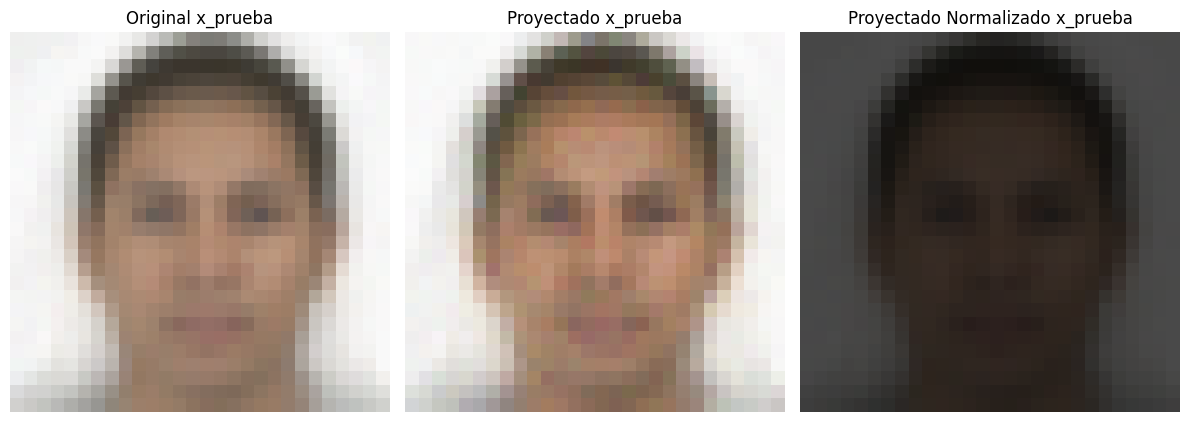

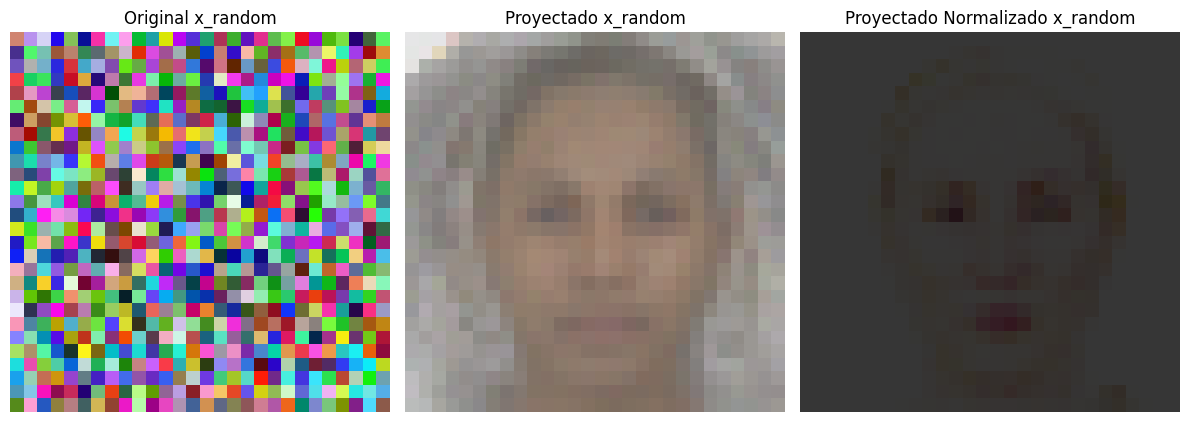

In [87]:
latent_sample = np.array([[0, 0,0,0 ,0,0,0,0,0,0,0, 0,0, 0,0,0,0,0,0,0,0, 0,0, 0,0,0,0,0,0,0]])
#latent_sample = np.zeros(latent_dim)
#latent_sample = np.expand_dims(latent_sample, axis=0)
x_prueba=decoderimg30.predict(latent_sample)
x_random = np.random.rand(*x_prueba.shape)  # Genera un vector aleatorio con la misma forma que x_prueba

# Proyecciones con project
x_prueba_proyectado = project(decoderimg30, x_prueba, iterations=50)
x_random_proyectado = project(decoderimg30, x_random, iterations=50)

# Proyecciones con project_normalized
x_prueba_proyectado_normalizado = project_normalized(decoderimg30, x_prueba, iterations=50)
x_random_proyectado_normalizado = project_normalized(decoderimg30, x_random, iterations=50)

# Función para mostrar imágenes
def mostrar_imagenes(original, proyectado, proyectado_normalizado, titulo):
    original = original.squeeze()
    proyectado = proyectado.squeeze()
    proyectado_normalizado = proyectado_normalizado.squeeze()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f'Original {titulo}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(proyectado, cmap='gray')
    plt.title(f'Proyectado {titulo}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(proyectado_normalizado, cmap='gray')
    plt.title(f'Proyectado Normalizado {titulo}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar las imágenes para x_prueba
mostrar_imagenes(x_prueba, x_prueba_proyectado, 10*x_prueba_proyectado_normalizado, "x_prueba")   #Se le coloca 4 para que en las imagenes  no se vea totalmente oscuro

# Mostrar las imágenes para x_random
mostrar_imagenes(x_random, x_random_proyectado, 10*x_random_proyectado_normalizado, "x_random")


El siguiente apartado se hizo con la intención de conocer el ajuste adecuado para la tasa de aprendizaje de la función project, lo que se esta haciendo es saber el error de reconstrucción (para project /||project|| y project_normalized), para un valor en la imagen y un vector aleatorio, se hicieron 5 intentos, se promediaron y luego se imprimieron en una gráfica.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


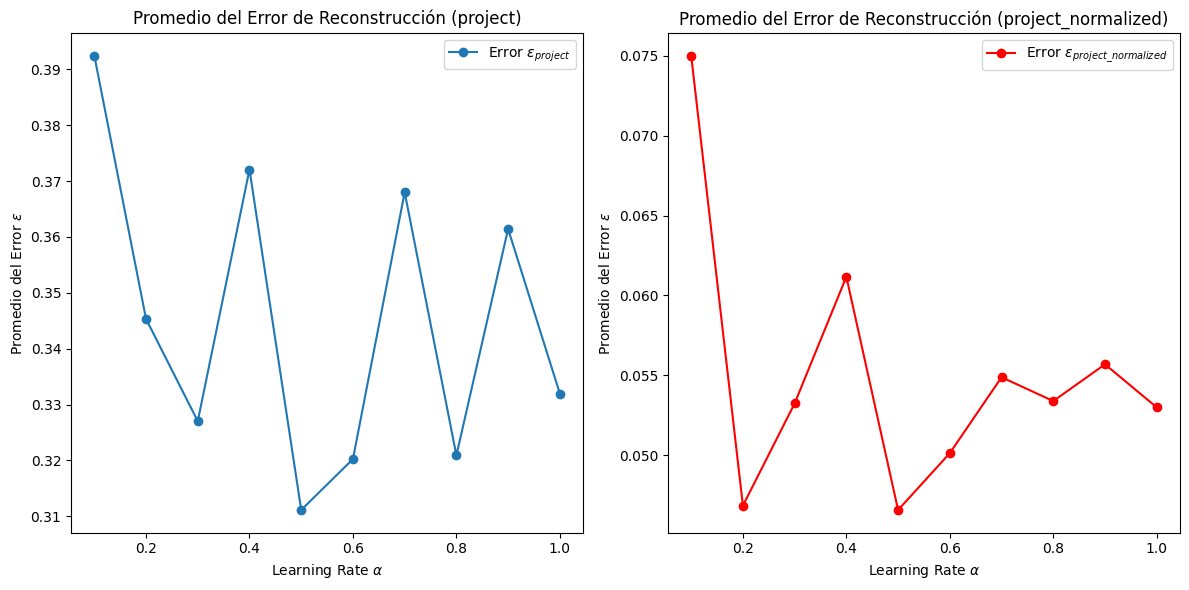

In [88]:

def graficar_errores(decoder, x_prueba, num_attempts, iterations_project):
    learning_rates =np.arange(0.1, 1.1, 0.1)

    errors_project = np.zeros(len(learning_rates))
    errors_project_normalized = np.zeros(len(learning_rates))

    for attempt in range(num_attempts):
        temp_errors_project = []
        temp_errors_project_normalized = []

        for lr in learning_rates:
            x_prueba_proyectado = project(decoder, x_prueba, iterations=iterations_project, learning_rate=lr)
            x_prueba_proyectado_normalizado = project_normalized(decoder, x_prueba, iterations=iterations_project, learning_rate=lr)

            err_reconstruccion_proyectado = np.linalg.norm(x_prueba - x_prueba_proyectado)
            err_reconstruccion_proyectado_normalizado = np.linalg.norm(x_prueba / np.linalg.norm(x_prueba) - x_prueba_proyectado_normalizado)

            temp_errors_project.append(err_reconstruccion_proyectado)
            temp_errors_project_normalized.append(err_reconstruccion_proyectado_normalizado)

        errors_project += np.array(temp_errors_project)
        errors_project_normalized += np.array(temp_errors_project_normalized)

    # Calcular el promedio de los errores
    errors_project /= num_attempts
    errors_project_normalized /= num_attempts

    # Gráfica del error de reconstrucción para 'project'
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(learning_rates, errors_project, marker='o', label=r'Error $\epsilon_{project}$')
    plt.title('Promedio del Error de Reconstrucción (project)')
    plt.xlabel(r'Learning Rate $\alpha$')
    plt.ylabel(r'Promedio del Error $\epsilon$')
    plt.legend()

    # Gráfica del error de reconstrucción para 'project_normalized'
    plt.subplot(1, 2, 2)
    plt.plot(learning_rates, errors_project_normalized, marker='o', color='red', label=r'Error $\epsilon_{project\_normalized}$')
    plt.title('Promedio del Error de Reconstrucción (project_normalized)')
    plt.xlabel(r'Learning Rate $\alpha$')
    plt.ylabel(r'Promedio del Error $\epsilon$')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Ejemplo de uso
latent_sample = np.array([[0, 0,0,0 ,0,0,0,0,0,0,0, 0,0, 0,0,0,0,0,0,0,0, 0,0, 0,0,0,0,0,0,0]])
#latent_sample = np.zeros(latent_dim)
#latent_sample = np.expand_dims(latent_sample, axis=0)
x_prueba=decoderM30.predict(latent_sample)
x_random = np.random.rand(*x_prueba.shape)

graficar_errores(decoderM30, x_prueba, num_attempts=5, iterations_project=50)




###**Iteración de potencias con proyección sobre imagen de un decoder**

Ahora procedemos hacer la iteración de potencias proyectada (Ppower como nombraron a este método en [1]), que consiste en hacer la iteración

 $$w^{(t+1)}=\mathcal{P}_G(\Sigma^T w^{(t)})$$   


 Para encontrar el vector propios dominante correspondiente a $\Sigma^T$, este lo hicmos para cada uno de los 3 canales (recordar que $\Sigma^T$ es un tensor de tamaño $m*n\times m*n\times 3$) y se hizo con ambos métpdos de proyección  (use_normalized_projection=True para utilizar project_normalized y use_normalized_projection=False para utilizar project y luego normalizar la salida )

In [11]:
def Ppower(Sigma, decoder, num_iterations_ppower=10, m=28, n=28, c=3, use_normalized_projection=True):
    # Obtener la dimensión latente desde la entrada del decoder
    latent_dim = decoder.input_shape[1]

    # Inicializar x con la columna de Sigma que tiene el valor absoluto más grande en la diagonal
    x = np.zeros((m, n, c))
    for channel in range(c):
        # Obtener la matriz Sigma para el canal actual
        Sigma_channel = Sigma[:, :, channel]

        # Encontrar el índice de la columna con el valor absoluto máximo en la diagonal
        diag_values = np.abs(np.diag(Sigma_channel))
        max_diag_index = np.argmax(diag_values)

        # Seleccionar la columna correspondiente
        x[:, :, channel] = Sigma_channel[:, max_diag_index].reshape(m, n)

    for t in range(num_iterations_ppower):
        # Multiplicación por Sigma
        x_tilde = np.zeros((m, n, c))
        for channel in range(c):
            x_flat = x[:, :, channel].flatten()  # Aplanar x para que coincida con las dimensiones de Sigma
            x_tilde_flat = np.dot(Sigma[:, :, channel], x_flat)  # Multiplicación por Sigma
            x_tilde[:, :, channel] = x_tilde_flat.reshape(m, n)  # Reorganizar en la forma original

        # Proyección en el rango de G
        if use_normalized_projection:
            x_projected = project_normalized(decoder, x_tilde)
        else:
            x_projected = project(decoder, x_tilde)
            x_projected_norm = np.linalg.norm(x_projected)
            x_projected = x_projected / x_projected_norm

        # Actualizar x para la siguiente iteración
        x = x_projected

    # Calcular valores propios aproximados
    lambdaRGB = np.zeros((c))
    for channel in range(c):
        x_channel = x[:, :, channel].flatten()  # Aplanar x para que coincida con las dimensiones de Sigma
        lambda_channel = x_channel.T @ Sigma[:, :, channel] @ x_channel  # Calcular valor propio
        lambdaRGB[channel] = lambda_channel

    return x.reshape(m, n, 3), lambdaRGB

In [89]:
def calculate_error_and_plot(Sigma, lambdaRGB, x, m=28, n=28, c=3):
    # Calcular el valor propio dominante y el vector propio dominante de Sigma
    lambda_max = np.zeros((c))
    eigenvectors = np.zeros((m*n, c))
    vectors_as_images = np.zeros((m, n, c))

    for channel in range(c):
        eigenvalues, eigenvectors_channel = np.linalg.eig(Sigma[:, :, channel])
        lambda_max[channel] = np.max(eigenvalues)
        # Obtener el vector propio correspondiente al valor propio dominante
        max_eigenvector_index = np.argmax(eigenvalues)
        eigenvectors[:, channel] = eigenvectors_channel[:, max_eigenvector_index]
        # Reconstruir la imagen a partir del vector propio dominante
        vector_image = eigenvectors[:, channel].reshape(m, n)
        vectors_as_images[:, :, channel] = vector_image

    # Calcular el error en relación con la diferencia entre x y el vector propio dominante
    error = np.zeros(c)
    for channel in range(c):
        x_channel = x[:, :, channel]
        vector_image = vectors_as_images[:, :, channel]
        error[channel] = np.linalg.norm(x_channel - vector_image)

    # Graficar el valor propio aproximado y el error
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Graficar la imagen aproximada
    axes[0, 0].imshow(30*x)
    axes[0, 0].set_title('Imagen Aproximada')

    # Graficar el vector propio dominante como imágenes
    axes[0, 1].imshow(10*vectors_as_images)
    axes[0, 1].set_title('Vector Propio Dominante')

    # Graficar los valores propios y el error
    channels = ['Rojo', 'Verde', 'Azul']
    x_pos = np.arange(len(channels))
    width = 0.35

    axes[1, 0].bar(x_pos - width/2, lambdaRGB, width, label='Valor Propio Aproximado')
    axes[1, 0].bar(x_pos + width/2, lambda_max, width, label='Valor Propio Dominante')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(channels)
    axes[1, 0].set_ylabel('Valor Propio')
    axes[1, 0].set_title('Comparación de Valores Propios')
    axes[1, 0].legend()

    # Graficar el error con el vector propio dominante
    axes[1, 1].bar(channels, error, color='orange')
    axes[1, 1].set_ylabel('Error')
    axes[1, 1].set_title('Error con Vector Propio Dominante')

    plt.show()

    return error

In [90]:
x,lambdaRGB=Ppower(SigmaT, decoderM30)



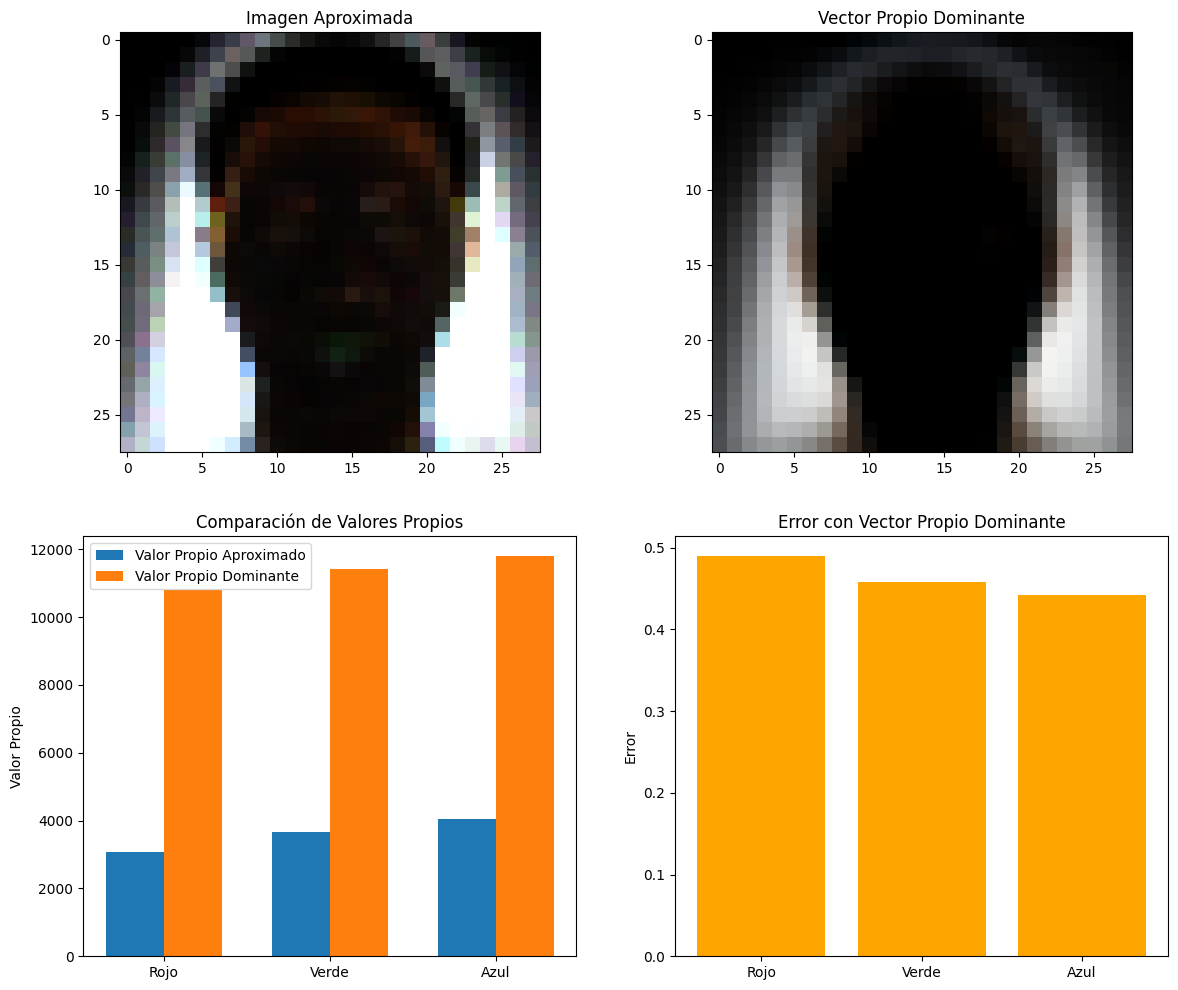

array([0.48944781, 0.45765988, 0.44251714])

In [91]:
calculate_error_and_plot(SigmaT, lambdaRGB, x, m=28, n=28, c=3)

Entrenamos el VAE con $M$ para distinos dimensiones del espacio latente, dejando fijo el tamaño del lote (bath_size=32), y la tasa de aprendizaje del optimizador de la función (Adam learning_rate=0.001), estos fueron los resultados de la reconstrucción del valor propio dominante de $\Sigma^T$, junto con la mejor tasa de aprendizaje para $P_G$ y la perdida del VAE

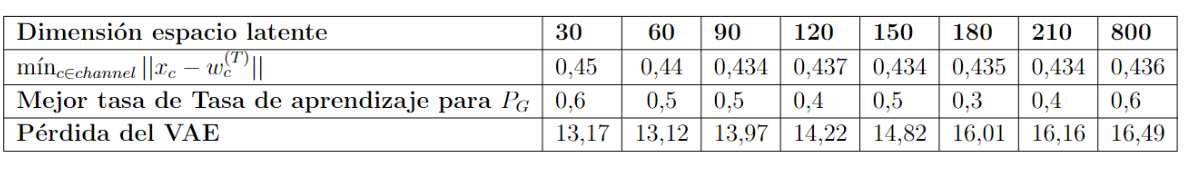

###**Iteración de potencias y deflación con proyección sobre imagen de un decoder**

Para terminar deflacionamos la matriz y reconstruimos una cara del data set proyectando sobre los vectores que hallamos (proyectando en el sentido de algera lineal, es decir haciendo el producto punto). Para el ejemplo que dejamos ejecutado reconstruimos  la primera cara del data set utilizando 8 vectores propios calculados con Ppower, (dado que la deflación se hacia bastante defectuosa dada la cantidad de error que exite en los valores propios, se deflaciono utilizando lo valores propios reales).

In [92]:
def Ppower_iteration_deflacion(k, num_iterations, Sigma, decoder, m=28, n=28):
    s = m * n  # Dimensión de los vectores propios
    v = np.zeros((k, 3))  # Se va a calcular k valores propios, 1 por cada canal
    V = np.zeros((s, k, 3))  # Se guardan los vectores propios
    A0 = Sigma.copy()

    # Calcula los valores propios reales de Sigma
    eigenvalues_all = []

    for channel in range(3):
        eigenvalues, _ = np.linalg.eig(Sigma[:, :, channel])
        eigenvalues_all.append(eigenvalues)

    eigenvalues_all = np.array(eigenvalues_all)

    for i in range(k):
        # Usa Ppower para obtener las imágenes aproximadas y los vectores propios calculados por Ppower
        x, lambdaRGB = Ppower(A0, decoder, num_iterations, m, n)  # Ppower devuelve 2 valores


        for channel in range(3):
            # Obtiene el valor propio real más grande
            eigenvalues = eigenvalues_all[channel]
            max_eigenvalue_index = np.argmax(eigenvalues)
            max_eigenvalue = eigenvalues[max_eigenvalue_index]

            v[i, channel] = lambdaRGB[channel]
            V[:, i, channel] = x[:, :, channel].flatten()

            # Deflacionar A0 usando el valor propio real más grande
            outer_product = np.outer(V[:, i, channel], V[:, i, channel])
            A0[:, :, channel] -= max_eigenvalue * outer_product

    return v, V

def reconstruir_imagenes(Images, V, num_caras):
    # Tamaños y número de vectores propios
    p, m, n, _ = Images.shape
    _, k, _ = V.shape

    # Inicializar las matrices de proyección y reconstrucción
    proyecciones = np.zeros((num_caras, k, 3))
    reconstrucciones = np.zeros((num_caras, m, n, 3))

    for i in range(num_caras):
        for channel in range(3):
            # Aplanar la imagen y los vectores propios del canal actual
            img_flat = Images[i, :, :, channel].flatten()
            V_flat = V[:, :, channel]

            # Calcular las proyecciones
            proyeccion = V_flat.T @ img_flat
            proyecciones[i, :, channel] = proyeccion

            # Reconstruir la imagen
            img_reconstruida_flat = V_flat @ proyeccion
            reconstrucciones[i, :, :, channel] = img_reconstruida_flat.reshape(m, n)

    return reconstrucciones

def mostrar_reconstrucciones(Images, reconstrucciones, num_caras):
    plt.figure(figsize=(15, 5))
    for i in range(num_caras):
        # Imagen original
        plt.subplot(2, num_caras, i + 1)
        plt.imshow(Images[i])
        plt.title("Original")
        plt.axis('off')

        # Imagen reconstruida
        plt.subplot(2, num_caras, num_caras + i + 1)
        plt.imshow(reconstrucciones[i])
        plt.title("Reconstrucción")
        plt.axis('off')

    plt.show()

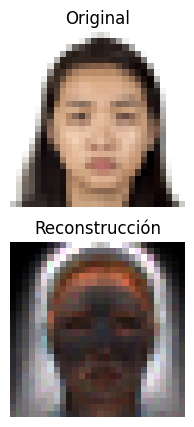

In [93]:
# Ejemplo de uso
k = 8  # Número de vectores propios a calcular
num_iterations_ppower = 10
m, n = 28, 28

v, V = Ppower_iteration_deflacion(k, num_iterations_ppower, SigmaT, decoderM30, m, n)

# Imágenes de ejemplo
Images =Images
num_caras = 1

reconstrucciones = reconstruir_imagenes(Images, V, num_caras)
mostrar_reconstrucciones(Images, reconstrucciones, num_caras)

##**Referencias**


1. Z. Li, J. Liu, S. Ghosh, J. Han, and J. Scarlett, “Generative principal component
analysis,” Applied Numerical Mathematics, vol. 169, 2021
2. Redes neuronales convolucionales: https://medium.com/@beingfarina/breaking-down-the-mathematics-behind-cnn-models-a-comprehensive-guide-1853aa6b011e
3. UnderstandingDeepLearning, Redes convolucionales pag 170: https://udlbook.github.io/udlbook/

4. J. C. y. B. W. Debbie S. Ma, “Cfd base de datos de caras de chicago.”
https://www.chicagofaces.org/, april 2015.
